In [176]:
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np
import logging
from gym_duckietown.simulator import Simulator
from casadi import *
import sys
sys.path.insert(0,'..')
import utils
from utils import get_trajectory, get_position, my_odometry

# Hyperparameters
gym_duckietown.logger.setLevel(logging.WARNING)
plt.rcParams['figure.figsize'] = [7, 7]
test_results = True
T = 15 # Simulation time
N = 10 # MPC horizon
n_from_index = 0 # How distant the first point is
frame_rate = 10
n_samples = 200

In [177]:
env = Simulator("ETH_large_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[3,1],
    seed=42,
    max_steps=float("inf"),
    robot_speed=1.0,
    frame_rate=frame_rate
)
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], np.pi/2]
dt = 1.0 / env.frame_rate
env.reset()
traj = get_trajectory(env, samples=n_samples, method="distance", last_value_distance=1)
inside, outside = utils.get_border(traj, distance=0.2)
x_min = traj[:,0].min()
y_min = traj[:,1].min()
#fig = plt.figure(constrained_layout=True, figsize=(10, 5))
#ax_dict = fig.subplot_mosaic("""AB""")
#ax_dict["A"].plot(*inside.T, "g--")
#ax_dict["A"].plot(*outside.T, "g--")
#utils.show_on_map_array(env, inside - np.array([-1.25, -1.5]), fig=ax_dict["B"])
#utils.show_on_map_array(env, outside- np.array([-1.25, -1.5]), fig=ax_dict["B"])
pose = get_position(env)

/home/giulio/prog/duckrace/utils.py:390: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_fitted = np.vstack( spl(alpha) for spl in splines ).T


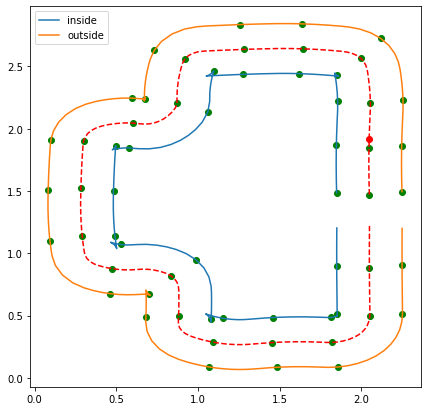

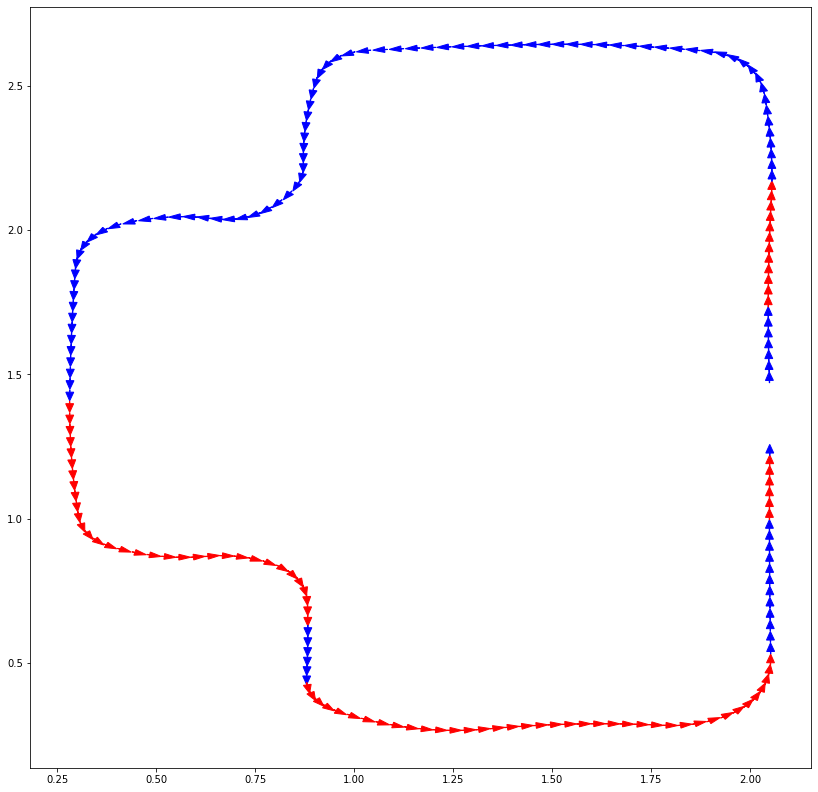

In [178]:
from scipy import spatial
distance,index = spatial.KDTree(traj).query([pose.x, pose.y])
pose.x = traj[index,0]
pose.y = traj[index,1]
index += n_from_index
fig = plt.figure(figsize=(7,7))
plt.plot(*traj.T, "r--")
plt.plot(*inside.T, label='inside')
plt.plot(*outside.T, label='outside')
plt.legend()
plt.scatter(pose.x, pose.y, c="r")
for idx in range(0,len(traj),10):
    plt.scatter(traj[idx,0], traj[idx,1], c="g")
    plt.scatter(inside[idx,0], inside[idx,1], c="g")
    plt.scatter(outside[idx,0], outside[idx,1], c="g")
f"Samples must be at least: {np.round(np.sum( np.sqrt(np.sum( np.diff(traj, axis=0)**2, axis=1 )) ) / (0.6*dt))}"
#utils.show_on_map_array(env, traj[:,:2] - np.array([-1.25, -1.5]))
# Compute the angle between every consecutive points in traj
angles = np.zeros(traj.shape[0])
angles[:-1] = np.arctan2(traj[1:,1]-traj[:-1,1], traj[1:,0]-traj[:-1,0])
angles[-1] = np.arctan2(traj[0,1]-traj[-1,1], traj[0,0]-traj[-1,0])
angles[angles < 0] += 2 * np.pi
#idx = []
#for i in range(len(angles)-1):
#    if mod((angles[i] - angles[i+1]),pi) >= pi/2:
#        idx.append(i)
# Add angles to traj
traj = np.concatenate((traj, angles.reshape(-1,1)), axis=1)
c="r"
fig = plt.figure(figsize=(14,14))
for x, y, t in traj:#[::3]:
    dx = 0.007*np.cos(t)
    if x+dx < x:
        c = "b"
    else:
        c = "r"
    plt.arrow(x, y, dx, 0.008*np.sin(t), color=c, head_width=0.02)

In [179]:
index = DM(index)
traj = DM(traj)

In [180]:
def model_F(dt=0.033):
    """
    Return the model casadi function tuned according to the parameter found in the thesis.

    :param dt: the time step
    """
    # IDEAL PARAMS
    # u1 = 5
    # u2 = 0
    # u3 = 0
    # w1 = 4
    # w2 = 0
    # w3 = 0
    # # parameters for forced dynamics
    # u_alpha_r = 1.5
    # u_alpha_l = 1.5
    # w_alpha_r = 15  # modify this for trim
    # w_alpha_l = 15

    # THESIS BY GUY
    # u1 = 7.662
    # u2 = 0.325
    # u3 = -0.050
    # w1 = 6.826
    # w2 = -4.929
    # w3 = -6.515
    # u_alpha_r = 2.755
    # u_alpha_l = 2.741
    # w_alpha_r = 10.8  # modify this for trim
    # w_alpha_l = 14.662

    # MANUAL
    # [7.662, 0.325, -0.050, 6.826, 0, 0, 2.755, 2.741, 14, 14.662]
    # u1 = 7.662
    # u2 = 0.325
    # u3 = -0.050
    # w1 = 6.826
    # w2 = 0
    # w3 = 0
    # u_alpha_r = 2.755
    # u_alpha_l = 2.741
    # w_alpha_r = 14
    # w_alpha_l = 14.662

    # FITTED wrt speed
    # [2.14148837,  0.12200042, -0.28237442,  1.3380637 ,  0.40072379, 1.30781483,  1.03762896,  0.62189597,  2.9650673 ,  2.89169198] 
    u1 = 2.14148837
    u2 = 0.12200042
    u3 = -0.28237442
    w1 = 1.3380637
    w2 = 0.40072379
    w3 = 1.30781483
    u_alpha_r = 1.30781483
    u_alpha_l = 1.03762896
    w_alpha_r = 2.9650673
    w_alpha_l = 2.89169198

    # Fitted wrt position
    # u1 = 4.3123709
    # u2 = 0.42117578
    # u3 = 0. 
    # w1 = 1.34991163
    # w2 = 0.66724572
    # w3 = 0.74908594
    # u_alpha_r = 2.27306332
    # u_alpha_l = 0.73258966
    # w_alpha_r = 3.12010274
    # w_alpha_l = 2.86162447
    # States
    x0 = MX.sym('x')
    y0 = MX.sym('y')
    th0 = MX.sym('th')
    w0 = MX.sym('w')
    v0 = MX.sym('v')
    x = vertcat(x0, y0, th0, v0, w0) # Always vertically concatenate the states --> [n_x,1]
    # Inputs
    wl = MX.sym('wl')
    wr = MX.sym('wr')
    u = vertcat(wl, wr) # Always vertically concatenate the inputs --> [n_u,1]
    
    # V =  [[wl], [wr]]
    V = vertcat(wr, wl)

    f_dynamic = vertcat(-u1 * v0 - u2 * w0 + u3 * w0 ** 2, -w1 * w0 - w2 * v0 - w3 * v0 * w0)
    # input Matrix
    B = DM([[u_alpha_r, u_alpha_l], [w_alpha_r, -w_alpha_l]])
    # forced response
    f_forced = B@V
    # acceleration
    X_dot_dot = f_dynamic + f_forced
    
    v1 = v0 + X_dot_dot[0] * dt
    w1 = w0 + X_dot_dot[1] * dt
    x1 = x0 + v0*dt*np.cos(th0 + w0*dt/2)
    y1 = y0 + v0*dt*np.sin(th0 + w0*dt/2)
    # Cannot use atan2 because x1 and y1 are approximated while th1 is not
    theta1 = th0 + w0*dt
    dae = vertcat(x1, y1, theta1, v1, w1)
    F = Function('F',[x,u],[dae],['x','u'],['dae'])
    return F

[2.04834, 1.91694, 1.5708, 0.234544, 0.00733753]


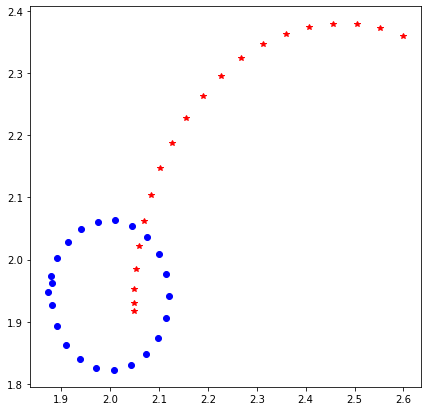

In [181]:
up = 5
wp = 4
# parameters for forced dynamics
u_alpha_r = 1.5
u_alpha_l = 1.5
w_alpha_r = 15  # modify this for trim
w_alpha_l = 15
# States
x0 = MX.sym('x')
y0 = MX.sym('y')
th0 = MX.sym('th')
v0 = MX.sym('v')
w0 = MX.sym('w')
x = vertcat(x0, y0, th0, v0, w0) # Always vertically concatenate the states --> [n_x,1]
# Inputs
wl = MX.sym('wl')
wr = MX.sym('wr')
u = vertcat(wl, wr) # Always vertically concatenate the inputs --> [n_u,1]
# System dynamics (CAN BE NONLINEAR! ;))
# x_long_dot_dot = -u1*v0 + u_alpha_r*wr + u_alpha_l*wl
# w_dot_dot = -w1*w0 + w_alpha_r*wr - w_alpha_l*wl
v1 = (1-up*dt)*v0 + u_alpha_r*dt*wr + u_alpha_l*dt*wl
w1 = (1-wp*dt)*w0 + w_alpha_r*dt*wr - w_alpha_l*dt*wl
x1 = x0 + v0*dt*np.cos(th0 + w0*dt/2)
y1 = y0 + v0*dt*np.sin(th0 + w0*dt/2)
# Cannot use atan2 because x1 and y1 are approximated while th1 is not
theta1 = th0 + w0*dt
dae = vertcat(x1, y1, theta1, v1, w1)
F = Function('F',[x,u],[dae],['x','u'],['dae'])


F = model_F(dt=1/frame_rate)
if test_results:
    print(F([pose.x, pose.y, pose.theta, 0, 0], [1, 1]))
N_test=20
# Test the problem definition
sim = F.mapaccum(N_test) # To call the F function N times
x0 = [pose.x, pose.y, pose.theta, 0, 0]

res = np.array(sim(x0, [1, 0.2]))
fig = plt.figure()
tgrid = np.linspace(0,T,N)
# plt.plot(tgrid, np.column_stack((x0, res)).T)
plt.plot(res[0, :], res[1, :], 'r*')
env.reset()
for action in [[1, 0.2]]*(N_test+3):
    obs, reward, done, info = env.step(action)
    p = get_position(env)
    plt.scatter(p.x, p.y, c='b')
_ = env.reset()

In [182]:
delay = round(0.15/dt)
u_delay0 = DM(np.zeros((2, delay)))
# N += delay

# Initial reference point
r0 = repmat(traj[index, :2].T, 1, N+1)
# Initial reference angles
t0 = repmat(traj[index, 2].T, 1, N+1)

# With preview
# Initial reference point
r0 = traj[index:index+N+1, :2].T
t0 = traj[index:index+N+1, 2].T
ins0 = DM(inside)[index:index+N+1, :].T
out0 = DM(outside)[index:index+N+1, :].T

In [183]:
#weights_0 = [1e3, 1e2, 1e-2, 1]
weights_0 = [1, 0, 0, 0]
gamma = 0.9
u_prev_0 = [.0, .0]

In [184]:
def position_cost(x,r):
    delta = 10
    return delta**2 * (np.sqrt(1 + (((x[0]-r[0])**2 + (x[1]-r[1])**2)/delta**2))-1)
def heading_cost(psi,tr):
    return (1 - np.cos(psi - tr))/2

In [185]:
angles = np.zeros(traj.shape)
angles[:-1] = np.arctan2(traj[1:,1]-traj[:-1,1], traj[1:,0]-traj[:-1,0])
angles[-1] = np.arctan2(traj[0,1]-traj[-1,1], traj[0,0]-traj[-1,0])
angles[angles < 0] += 2 * np.pi

In [186]:
opti = Opti()
######################## VARIABLE/PARAMETERS ############################################################
x = opti.variable(5,N+1)            # States with dimension (n_x, prediction_horizon+1) (x(0),...,x(N+1))
u = opti.variable(2,N)#-delay)      # Inputs with dimension (n_u, prediction_horizon) (u(0),...,u(N))
#slack1 = opti.variable(1,N)         # slack variable 1
#slack2 = opti.variable(1,N)         # slack variable 2
p = opti.parameter(5,1)             # Parameter to set the initial state conditions (x(0))
r = opti.parameter(2,N+1)           # Parameter to set the reference position (r(0),...,r(N+1))
tr = opti.parameter(1,N+1)          # Parameter to set the reference angles
#ins = opti.parameter(2,N+1)         # Parameter to set the inside boundary
#out = opti.parameter(2,N+1)         # Parameter to set the outside boundary
u_delay = opti.parameter(2,delay)   # Parameter to set the delay (NOT USED)
u_prev = opti.parameter(2,1)        # Parameter to set previus input value (u(-1))
weights = opti.parameter(4)         # Parameter for the cost function weights  
#theta = opti.parameter(4)           # Additional learned parameters
######################## COST FUNCTION WEIGHTS ############################################################
Q1 = weights[0]
Q2 = weights[1]
Q3 = weights[2]
R = weights[3]

#theta_lambda = theta[0]
# theta_f_1 = theta[1]
# theta_f_2 = theta[2]
# theta_f_3 = theta[3]
######################## INITIAL VALUES ############################################################
cost = Q1*sumsqr(x[:2, 0] - r[:,0]) +\
       Q2*heading_cost(x[2, 0],tr[:,0]) +\
       Q3*sumsqr(x[3, 0]-0.6) +\
       R*sumsqr(u[:,0]-u_prev)# initial cost #theta_lambda +\

opti.subject_to(x[:,1]==F(x[:,0],u[:,0]))         # system dynamics (k=0)
opti.subject_to(x[:,0] == p)                      # set initial x_0
######################## STAGE COST/RECURSIVE CONTRAINTS ############################################################
for k in range(1,N):
    cost += gamma**k * (Q1*sumsqr(x[:2, k] - r[:,k]) +\
                        #Q2*sumsqr(fmin(2*np.pi - fabs(mod(x[2, k],2*pi)-tr[:,k]), fabs(mod(x[2, k],2*pi)-tr[:,k]))) +\
                        Q2*heading_cost(x[2, k],tr[:,k]) +\
                        Q3*sumsqr(x[3, k]-0.6) +\
                        #Q4*sumsqr(x[4, k]) +\
                        R*sumsqr(u[:,k]-u[:,k-1])# +\
                        #1e2*slack1[:,k] + 1e2*slack2[:,k]
                        )
    opti.subject_to(x[:,k+1]==F(x[:,k],u[:,k]))
    # opti.subject_to(sumsqr(x[:2,k]) + slack1[:,k] >= sumsqr(ins[:,k]))
    # opti.subject_to(sumsqr(x[:2,k]) - slack2[:,k] <= sumsqr(out[:,k]))
######################## TERMINAL COST/CONSTRAINTS ############################################################
#cost += gamma**N * (theta_f_1*sumsqr(x[:2, N]-r[:,N])+ theta_f_2*heading_cost(x[2, k],tr[:,k]) + theta_f_3*sumsqr(x[3, k]-0.6))
######################## ADDITIONAL PARAMETERS ############################################################
opti.subject_to(vec(u) <= 0.5)               # actuator LB
opti.subject_to(vec(u) >= 0)              # actuator LB
opti.subject_to(x[3,:] >= 0)               # Enforce forward movement
#opti.subject_to(vec(slack1) >= 0)          # slack 1 condition
#opti.subject_to(vec(slack2) >= 0)          # slack 2 condition
######################## INITIALIZE PARAMETERS ############################################################
opti.set_value(p,[pose.x, pose.y, pose.theta, 0, 0]) # Set the initial x0 value
opti.set_value(r,r0) # Set the initial reference points
opti.set_value(tr,t0) # Set the initial reference angles
#opti.set_value(ins,ins0) # Set the initial reference angles
#opti.set_value(out,out0) # Set the initial reference angles
opti.set_value(u_delay, u_delay0) # Initial delay
opti.set_value(u_prev, u_prev_0) # Initial delay
opti.set_value(weights, weights_0)
#opti.set_value(theta, theta_0) 
######################## SOLVER SPECIFICATIONS ############################################################
# Ipopt
opts = dict()
opts["ipopt.print_level"] = 0
opts["print_time"] = False
opti.solver('ipopt',opts)
opti.minimize(cost)
######################## CREATE VALUE FUNCTION V(s) ############################################################
M = opti.to_function('M',[p, r, tr, u_delay, u_prev, weights], # inputs
                         [u[:,0]], # outputs
                         ['p', 'r', 'tr','u_delay', 'u_prev', 'weights'],
                         ['u_opt'])
######################## TESTING ############################################################
# Test over 1 time horizon
if test_results:
    sol = opti.solve()

In [187]:
# MPC loop
gamma = 0.9
weights_0 = [1e5, 1, 1e2, 1]

lap_dict = dict()


X_log = np.empty((5,0))
U_log = np.empty((2,0))

x = [pose.x, pose.y, pose.theta, 0, 0]
# start_angle = np.arctan2(x[1], x[0])
# start_angle = start_angle if start_angle >= 0 else start_angle + 2*np.pi
x_prev = x
r = r0
tr = t0
# ins = ins0
# out = out0
idx = index
u_delay = u_delay0
u_prev = u_prev_0
errors = []
error_x = []
error_y = []
error_theta = []
it_vect = []
weights_vect = []

kdtree = spatial.KDTree(traj[:, :2])

#_,start_idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))

x_prev = x
i_prev = 0

t = 0
flag = False

#fig, ax = plt.subplots()

#ax.plot(traj[:,0], traj[:,1], "b--")
#ax.plot(*inside.T, "b")
#ax.plot(*outside.T, "b")
#t1 = ax.text(1.2, 1.5,"Iteration: 0, Last time: {:.2f}s".format(X_log.shape[1]*dt), ha='center', va='center')
#plt.draw()

for i in range(300):

    a = M(x, r, tr, u_delay, u_prev, weights_0)

    U_log = np.column_stack((U_log, a))
    X_log = np.column_stack((X_log, x))

    #u_delay = np.column_stack((u_delay, a))[:, -delay:]

    # simulate
    x_next = F(x,a)
    
    x_prev = x
    u_prev = a

    x = x_next
    
    distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
    it_vect.append(i)
    errors.append(np.sqrt(distance))
    error_x.append(traj[idx, 0] - x[0])
    error_y.append(traj[idx, 1] - x[1])
    error_theta.append(mod(x[2],2*np.pi)-traj[idx, 2])
    weights_vect.append(DM(weights_0))

    _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
    
    # current_angle = np.arctan2(x[1], x[0])
    # current_angle = current_angle if current_angle >= 0 else current_angle + 2*np.pi

    # if i > 5 and (float(current_angle) - start_angle >= - 0.05 and float(current_angle) - start_angle <= 0.05):
    #     print('Lap %i'%(len(lap_dict)+1))
    #     lap_dict[len(lap_dict)+1] = [it_vect[i_prev:], X_log[:,i_prev:], U_log[:,i_prev:], weights_vect[i_prev:]]
    #     i_prev = i
    
    if idx+N+1 < traj.shape[0]:
        r = traj[idx:idx+N+1, :2].T
        tr = traj[idx:idx+N+1, 2].T
        #ins = DM(inside)[idx:idx+N+1, :].T
        #out = DM(outside)[idx:idx+N+1, :].T
    else:
        r = vertcat(traj[idx:, :2], traj[:idx+N+1-traj.shape[0], :2]).T
        tr = vertcat(traj[idx:, 2], traj[:idx+N+1-traj.shape[0], 2]).T

        #ins = vertcat(DM(inside)[idx:, :], DM(inside)[:idx+N+1-inside.shape[0], :]).T
        #out = vertcat(DM(outside)[idx:, :], DM(outside)[:idx+N+1-inside.shape[0], :]).T
        #ax.plot(*X_log[:2,:], c='r')
        #ax.text(0,0,"Steps: {iteration} Last time: {time:.2f}s".format(iteration=i, time=X_log.shape[1]*dt))
        #plt.draw()
        #ipythondisplay.clear_output(wait=True)
        #ipythondisplay.display(plt.gcf())
    #r = traj[idx:idx+N+1, :2].T
    #tr = traj[idx:idx+N+1, 2].T

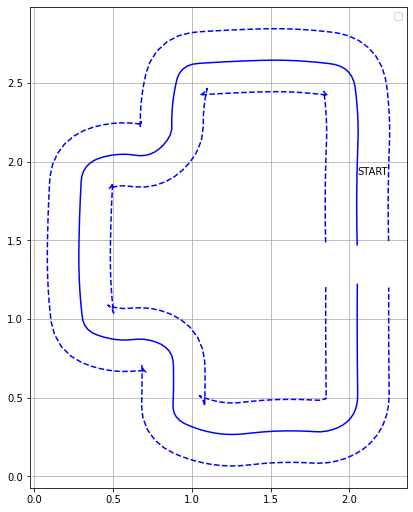

In [188]:
fig = plt.figure(constrained_layout=True)
traj = np.array(traj)
index = int(index)
ax_dict = fig.subplot_mosaic("""A""")
ax_dict["A"].plot(traj[:,0], traj[:,1], "b")
ax_dict["A"].plot(inside[:,0], inside[:,1], "b--")
ax_dict["A"].plot(outside[:,0], outside[:,1], "b--")
ax_dict["A"].text(X_log[0,0], X_log[1,0], 'START')

for i, (key, val) in enumerate(lap_dict.items()):
    #print(val[1].shape)
    if i%2==0:
        ax_dict["A"].plot(val[1][0,:], val[1][1,:], label='Lap n. %i'%(i+1))
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal')

In [189]:
f"Max reached speed: {X_log[3,:].max()}, max speed is 0.6"

'Max reached speed: 0.447654629346366, max speed is 0.6'

In [190]:
errors = np.array(errors).reshape(-1)
f"Mean error: {errors.mean()}"

'Mean error: 0.04401952214449589'

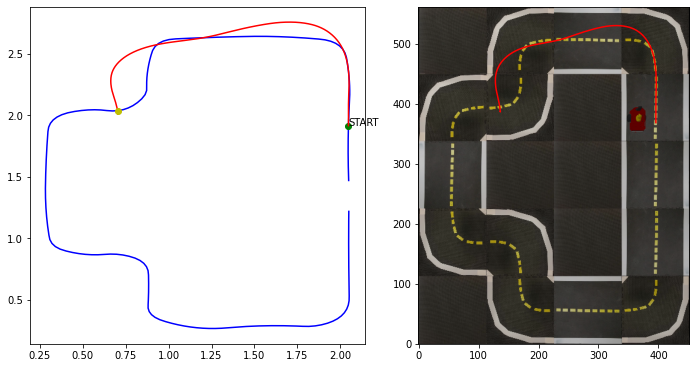

In [191]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ax_dict = fig.subplot_mosaic("""AC""")
ax_dict["A"].text(X_log[0,0], X_log[1,0], 'START')
ax_dict["A"].plot(traj[:,0], traj[:,1], "b")
ax_dict["A"].plot(traj[index,0], traj[index,1], 'go')
ax_dict["A"].plot(X_log[0,:], X_log[1,:], "r")
ax_dict["A"].plot(traj[idx, 0], traj[idx,1], 'yo')
utils.show_on_map_array(env, np.array([X_log[0,:], X_log[1,:]]).T, fig=ax_dict["C"])

Text(0, 0.5, 'Distance from reference (m)')

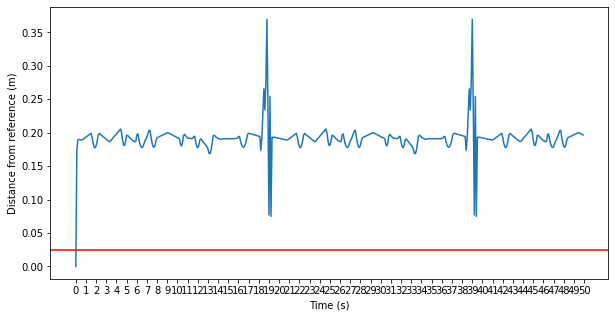

In [38]:
plt.figure(figsize=(10,5))
plt.xticks(np.arange(0, len(errors)*dt+1, 1.0))
plt.plot(np.arange(len(errors))*dt, np.sqrt(errors))
plt.axhline(y=0.025, color='r', linestyle='-')
plt.xlabel("Time (s)")
plt.ylabel("Distance from reference (m)")

Text(0.5, 0, 'Time (s)')

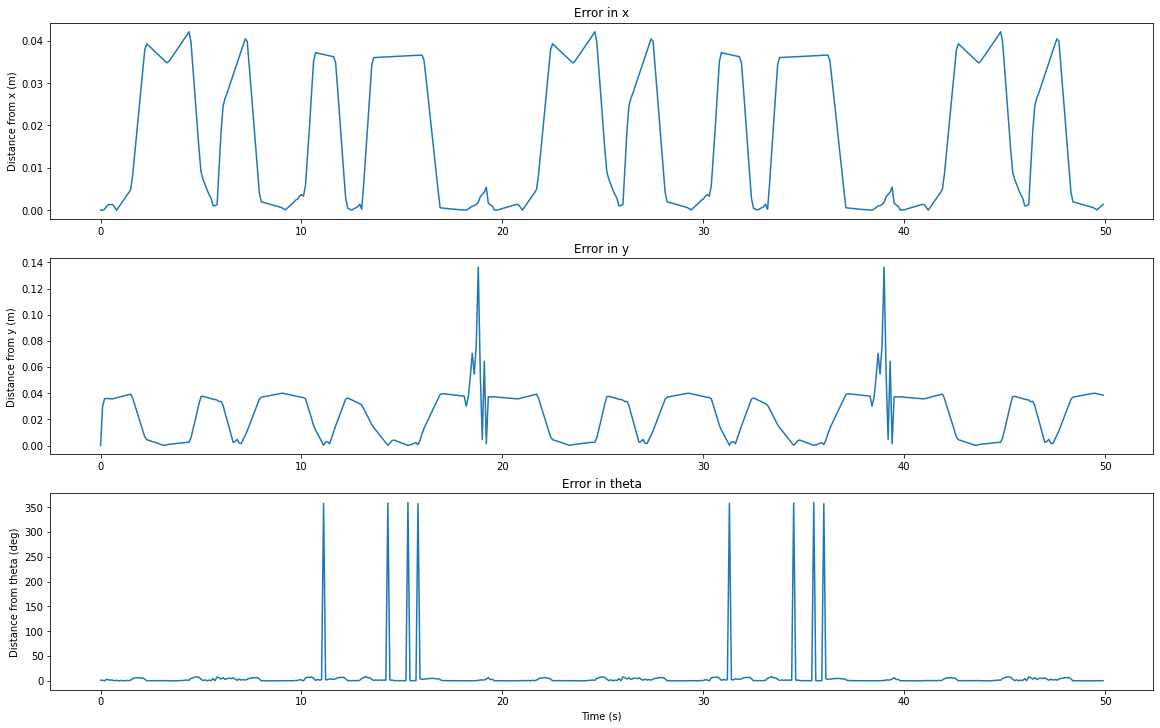

In [39]:
fig = plt.figure(constrained_layout=True, figsize=(16, 10))
ax_dict = fig.subplot_mosaic("""A
        B
        C""")
error_x = np.array(error_x).reshape(-1)
ax_dict["A"].plot(np.arange(len(error_x))*dt, np.abs(error_x))
ax_dict["A"].set_title("Error in x")
ax_dict["A"].set_ylabel("Distance from x (m)")
error_y = np.array(error_y).reshape(-1)
ax_dict["B"].plot(np.arange(len(error_y))*dt, np.abs(error_y))
ax_dict["B"].set_title("Error in y")
ax_dict["B"].set_ylabel("Distance from y (m)")
error_theta_scaled = np.rad2deg(np.array(error_theta).reshape(-1))
ax_dict["C"].plot(np.arange(len(error_theta_scaled))*dt, np.abs(error_theta_scaled))
ax_dict["C"].set_title("Error in theta")
ax_dict["C"].set_ylabel("Distance from theta (deg)")
ax_dict["C"].set_xlabel("Time (s)")

## Parameters sensitivity

In [40]:
td_graph = False

### Multi parameter sensitivity

In [41]:
if td_graph:
    errors_Q = []

    for Q_ in np.logspace(-4, 2, 20):
        errors_Q2 = []
        for Q2_ in np.logspace(-4, 2, 20):
            X_log = np.empty((5,0))
            U_log = np.empty((2,0))

            x = [pose.x, pose.y, pose.theta, 0, 0]
            r = r0
            tr = t0
            idx = index
            u_delay = u_delay0
            errors = []
            error_x = []
            error_y = []
            error_theta = []

            kdtree = spatial.KDTree(traj[:, :2])
            for i in range(50):
                u = M(x, r, tr, u_delay, Q_, Q2_, 1, 1)

                U_log = np.column_stack((U_log, u))
                X_log = np.column_stack((X_log, x))

                u_delay = np.column_stack((u_delay, u))[:, -delay:]

                # simulate
                x = F(x,u)

                distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
                errors.append(distance)
                error_x.append(traj[idx, 0] - x[0])
                error_y.append(traj[idx, 1] - x[1])
                error_theta.append(mod(x[2]-traj[idx, 2]+pi, 2*pi)-pi)

                _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
                r = traj[idx:idx+N+1, :2].T
                tr = traj[idx:idx+N+1, 2].T
            errors_Q2.append(np.array(errors).reshape(-1).sum())
        errors_Q.append(errors_Q2)

In [42]:
if td_graph:
    import matplotlib.ticker as mticker
    import matplotlib as mpl

    mpl.style.use("default")
    ax = plt.axes(projection='3d')
    ax.plot_wireframe(np.log10(np.logspace(-4, 2, 20)), np.log10(np.logspace(-4, 2, 20)), np.array(errors_Q), label="J")

    # My axis should display 10⁻¹ but you can switch to e-notation 1.00e+01
    def log_tick_formatter(val, pos=None):
        return f"$10^{{{int(val)}}}$"  # remove int() if you don't use MaxNLocator
        #return f"{10**val:.2e}"      # e-Notation

    ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    ax.set_xlabel('Q1', fontsize=15, rotation=0, labelpad=10)
    ax.set_ylabel('Q2', fontsize=15, labelpad=15)
    ax.set_zlabel('J', fontsize=15, rotation=0, labelpad=10)
    ax.yaxis.set_rotate_label(False)

    ax.grid(True)

    ax.set_title('Q1 vs Q2')

#### Sensitivity to Q1/Q2
FIxed Q3 and R

In [56]:
errors_Q = []

for Q_ in np.logspace(-2, 3, 30):
    X_log = np.empty((5,0))
    U_log = np.empty((2,0))

    x = [pose.x, pose.y, pose.theta, 0, 0]
    r = r0
    tr = t0
    idx = index
    u_delay = u_delay0
    errors = []
    error_x = []
    error_y = []
    error_theta = []

    u = [0,0]

    kdtree = spatial.KDTree(traj[:, :2])
    for i in range(50):
        u = M(x, r, tr, u_delay, u, [Q_, 1, 1e2, 1])

        U_log = np.column_stack((U_log, u))
        X_log = np.column_stack((X_log, x))

        u_delay = np.column_stack((u_delay, u))[:, -delay:]

        # simulate
        x = F(x,u)

        distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
        errors.append(distance)
        error_x.append(traj[idx, 0] - x[0])
        error_y.append(traj[idx, 1] - x[1])
        error_theta.append(mod(x[2]-traj[idx, 2]+pi, 2*pi)-pi)

        _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
        r = traj[idx:idx+N+1, :2].T
        tr = traj[idx:idx+N+1, 2].T
    errors_Q.append(np.array(errors).reshape(-1).sum())

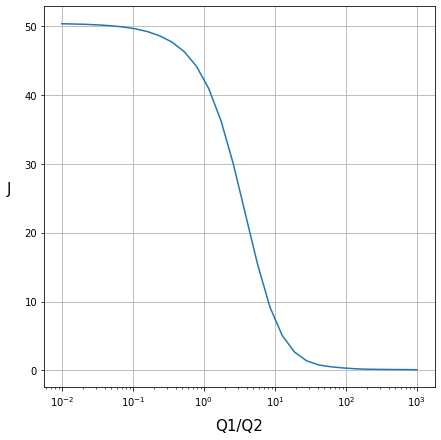

In [57]:
fig, ax = plt.subplots()
x = np.logspace(-2, 3, 30)
ax.plot(x, errors_Q)
ax.set_xlabel('Q1/Q2', fontsize=15, rotation=0, labelpad=10)
ax.set_ylabel('J', fontsize=15, labelpad=15, rotation=0)
ax.grid()

# Set x scale to logarithmic
ax.set_xscale('log')

### Sensitivity to Q1 vs Q3

In [45]:
errors_Q2 = []

for Q2_ in np.logspace(-2, 3, 30):
    X_log = np.empty((5,0))
    U_log = np.empty((2,0))

    x = [pose.x, pose.y, pose.theta, 0, 0]
    r = r0
    tr = t0
    idx = index
    u_delay = u_delay0
    errors = []

    u = [0,0]

    kdtree = spatial.KDTree(traj[:, :2])
    for i in range(50):
        u = M(x, r, tr, u_delay, u, [Q2_, 1e-2, 1, 1])

        U_log = np.column_stack((U_log, u))
        X_log = np.column_stack((X_log, x))

        u_delay = np.column_stack((u_delay, u))[:, -delay:]

        # simulate
        x = F(x,u)

        distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
        errors.append(distance)

        _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
        r = traj[idx:idx+N+1, :2].T
        tr = traj[idx:idx+N+1, 2].T
    errors_Q2.append(np.array(errors).reshape(-1).sum())

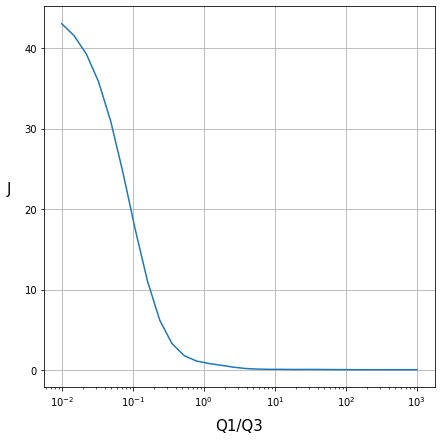

In [46]:
fig, ax = plt.subplots()
x = np.logspace(-2, 3, 30)
ax.plot(x, errors_Q2)
ax.set_xlabel('Q1/Q3', fontsize=15, rotation=0, labelpad=10)
ax.set_ylabel('J', fontsize=15, labelpad=15, rotation=0)
ax.grid()

# Set x scale to logarithmic
ax.set_xscale('log')

### Sensitivity to Q2/Q3

In [47]:
errors_Q3 = []

for Q3_ in np.logspace(-5, 5, 40):
    X_log = np.empty((5,0))
    U_log = np.empty((2,0))

    x = [pose.x, pose.y, pose.theta, 0, 0]
    r = r0
    tr = t0
    idx = index
    u_delay = u_delay0
    errors = []

    u = [0,0]

    kdtree = spatial.KDTree(traj[:, :2])
    for i in range(50):
        u = M(x, r, tr, u_delay, u, [1e2, Q3_, 1, 1])

        U_log = np.column_stack((U_log, u))
        X_log = np.column_stack((X_log, x))

        u_delay = np.column_stack((u_delay, u))[:, -delay:]

        # simulate
        x = F(x,u)

        distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
        errors.append(distance)

        _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
        r = traj[idx:idx+N+1, :2].T
        tr = traj[idx:idx+N+1, 2].T
    errors_Q3.append(np.array(errors).reshape(-1).sum())

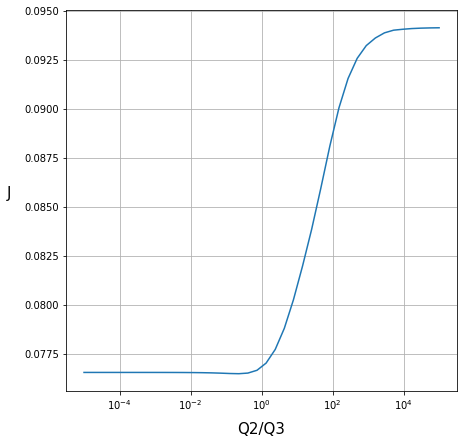

In [48]:
fig, ax = plt.subplots()
x = np.logspace(-5, 5, 40)
ax.plot(x, errors_Q3)

ax.set_xlabel('Q2/Q3', fontsize=15, rotation=0, labelpad=10)
ax.set_ylabel('J', fontsize=15, labelpad=15, rotation=0)
ax.grid()

# Set x scale to logarithmic
ax.set_xscale('log')

### Sensitivity to R

In [49]:
sens_R = False

if sens_R:
    errors_R = []

    for R_ in np.logspace(-4, 2, 20):
        X_log = np.empty((5,0))
        U_log = np.empty((2,0))

        x = [pose.x, pose.y, pose.theta, 0, 0]
        r = r0
        tr = t0
        idx = index
        u_delay = u_delay0
        errors = []

        u = [0,0]

        kdtree = spatial.KDTree(traj[:, :2])
        for i in range(50):
            u = M(x, r, tr, u_delay, u, [100, 5e-4, 1, R_])

            U_log = np.column_stack((U_log, u))
            X_log = np.column_stack((X_log, x))

            u_delay = np.column_stack((u_delay, u))[:, -delay:]

            # simulate
            x = F(x,u)

            distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
            errors.append(distance)

            _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
            r = traj[idx:idx+N+1, :2].T
            tr = traj[idx:idx+N+1, 2].T
        errors_R.append(np.array(errors).reshape(-1).sum())

In [50]:
if sens_R:
    fig, ax = plt.subplots()
    x = np.logspace(-4, 2, 20)
    ax.plot(x, errors_R)

    # Set x scale to logarithmic
    ax.set_xscale('log')

If you want to save the MPC controller, i.e. the M function for later use, you can do it!

In [159]:
M.save('controllers/M_ric_N10_manual_200p_speed05.casadi')

### Gym simulation

The MPC does not consider the delay yet!

In [52]:
record = False

if record:
    import imageio
    import cv2

    env.reset()
    pose = get_position(env)
    images = []
    positions = []
    odoms = [pose]
    actions = [[0,0]]*10
    v0 = 0
    w0 = 0
    for action in U_log.T:
        env.step(action)
        positions.append(get_position(env))
        img = env.render(mode='rgb_array')
        img = cv2.resize(img, dsize=(400, 300), interpolation=cv2.INTER_CUBIC)
        images.append(img)

        p, v0, w0 = my_odometry(action, odoms[-1].x, odoms[-1].y, odoms[-1].theta, v0, w0, dt=dt)
        odoms.append(p)
        actions.append(action)

    imageio.mimsave("assets/mpc_run.gif", images, format='GIF', fps=env.frame_rate)

In [53]:
if record:
    plt.plot(*np.array([[p.x, p.y] for p in positions]).T, c='g', label='true', linewidth=5)
    plt.plot(*np.array([[p.x, p.y] for p in odoms]).T, c='r', label='odom')
    plt.legend()

In [54]:
if record:
    utils.show_on_map(env, positions)

In [55]:
from IPython.display import HTML, display
# Trick to prevent cache use
display(HTML('<img src="assets/mpc_run.gif?%d" width="750" align="center">' % np.random.randint(10)))